In [ ]:
#@title Copyright 2020 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Detecting Changes in Sentinel-1 Imagery (Part 3)

Author: mortcanty




### Run me first

Run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [6]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=JcedXEjMfxIK6ZzDlrxrtQgziElWJENVZ3mA__WmKkM&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/4QFfLTo5c2tbiGOrvomn5tEgB33MP9hVWjNhbWs8BDwDm-4Fdc98Wtc

Successfully saved authorization token.


### Datasets and Python modules
One [dataset](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD) will be used in the tutorial:
- COPERNICUS/S1_GRD_FLOAT
  - Sentinel-1 ground range detected images

The following cell imports some python modules which we will be using as we go along and enables inline graphics.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import time
%matplotlib inline

And to make use of interactive graphics, we import the _folium_ package:

In [8]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

## Part 3. Multitemporal change detection


Continuing from Part 2, in which we discussed bitemporal change detection with Sentinel 1 images, we turn our attention to the multitemporal case. To get started, we obviously need  a time series. 

### A time series

Here is a fairly interesting one: a region in South Yorkshire, England where, in November 2019, extensive flooding occurred along the River Don just north of the city of Doncaster.

In [9]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -1.2998199462890625,
              53.48028242228504
            ],
            [
              -0.841827392578125,
              53.48028242228504
            ],
            [
              -0.841827392578125,
              53.6958933974518
            ],
            [
              -1.2998199462890625,
              53.6958933974518
            ],
            [
              -1.2998199462890625,
              53.48028242228504
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

The image collection below covers the months of Spetember, 2019 through January, 2020 at 6-day intervals:

In [10]:
im_coll = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
                .filterBounds(aoi) \
                .filterDate(ee.Date('2019-09-01'),ee.Date('2020-01-31')) \
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 132)) \
                .sort('system:time_start')

acq_times = im_coll.aggregate_array('system:time_start').getInfo()
[time.strftime('%x',time.gmtime(acq_time/1000)) for acq_time in acq_times]               

['09/06/19',
 '09/12/19',
 '09/18/19',
 '09/30/19',
 '10/06/19',
 '10/12/19',
 '10/18/19',
 '10/24/19',
 '10/30/19',
 '11/05/19',
 '11/11/19',
 '11/17/19',
 '11/23/19',
 '11/29/19',
 '12/05/19',
 '12/11/19',
 '12/17/19',
 '12/23/19',
 '12/29/19',
 '01/04/20',
 '01/10/20',
 '01/16/20',
 '01/22/20',
 '01/28/20']

(Actually there is one missing acquisition, namely for September 24, 2019.) 

It will turn out to be more convenient to work with a list rather than a collection, so:

In [11]:
im_list = im_coll.toList(100)
im_list.length().getInfo()

24

Here is an rgb composite of the VV bands of the first three images, after conversion to decibels and clipping to the AOI. Note that some changes already show up in this representation as colored pixels.

In [12]:
def selectvv(current):
    return ee.Image(current).select('VV')

vv_list = im_list.map(selectvv)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=11, height=800, width=1000)
images = ee.Image.rgb(vv_list.get(0),vv_list.get(1),vv_list.get(2)).log10().multiply(10).clip(aoi)
mp.add_ee_layer(images, {'min': -20,'max': 0}, 'First three images')
mp.add_child(folium.LayerControl())

display(mp)

Now we have a series of 24 SAR images and, for whatever reason, would like to know where and when changes have taken place. A first reaction might be: 
 
*What's the problem? Just apply the bitemporal method we developed in Part 2 to each of the 23 time intervals.*
 
Well, the problem is the rate of false positives. If the bitemporal tests are statistically independent, then the probability of **not** getting a false positive over a series of length $k$ is the product of not getting one in each of the $k-1$ intervals, i.e., $(1-\alpha)^{k-1}$ and the overall first kind error probabilty $\alpha_T$ is its complement:
 
$$
\alpha_T = 1-(1-\alpha)^{k-1}. \tag{3.1}
$$
 
For our case, even with a small value of $\alpha=0.01$, this gives a whopping 20.6% false positive rate:

In [13]:
alpha = 0.01
1-(1-alpha)**23  

0.20638571635634462

Actually things are a even worse. The bitemporal tests are manifestly not independent because all consecutive tests have one image in common. For instance, let's take random samples from the bitemporal LRT statistics (monovariate case) 

$$
{s_0\over s_1}, {s_1\over s_2}, \dots , {s_{k-1}\over s_k}
$$

and calculate their correlation matrix. (This is perhaps overkill to illustrate a simple point, but it introduces the important technique of iterating over an _ee:List()_ object, which will be used extensively later.)


In [14]:
def list_iter(current,prev):
    '''The iteration algorithm:'''    
#  Get current index i from the list. 
    i = ee.Number(current)
#  Extract aoi, vv_list and list of samples from previous iteration.
    prev = ee.Dictionary(prev)
    aoi = prev.get('aoi')
    vv_list = ee.List(prev.get('vv_list'))
    samples = ee.List(prev.get('samples'))
#  Sample the ratio s_i/s_(i+1).    
    sample = ee.Image(vv_list.get(i)).divide(vv_list.get(i.add(1))) \
                 .clip(aoi) \
                 .sample(scale=10, numPixels=5000, seed=123) \
                 .aggregate_array('VV')
#  Return the prev dictionary, appending the current sample to the list of samples.                  
    return ee.Dictionary({'aoi': aoi, 'vv_list': vv_list, 'samples': samples.add(sample)})

# Initialize the iteration with an empty list.
first = ee.Dictionary({'aoi': aoi, 'vv_list': vv_list, 'samples': ee.List([])})
# iterate over the list indices [0,1,...,22]
result = ee.List.sequence(0,22).iterate(list_iter,first)

We examine the upper left $8\times 8$ corner of the correlation matrix:

In [15]:
samples = ee.List(ee.Dictionary(result).get('samples'))
np.set_printoptions(precision=2, suppress=True)
print( np.corrcoef(samples.getInfo())[:8,:8] )

[[ 1.   -0.28 -0.03  0.03 -0.   -0.01  0.02 -0.01]
 [-0.28  1.   -0.18 -0.02  0.    0.02 -0.03  0.06]
 [-0.03 -0.18  1.   -0.1  -0.05  0.03  0.01  0.01]
 [ 0.03 -0.02 -0.1   1.   -0.12  0.02 -0.01  0.17]
 [-0.    0.   -0.05 -0.12  1.   -0.32 -0.03 -0.01]
 [-0.01  0.02  0.03  0.02 -0.32  1.   -0.26  0.03]
 [ 0.02 -0.03  0.01 -0.01 -0.03 -0.26  1.   -0.18]
 [-0.01  0.06  0.01  0.17 -0.01  0.03 -0.18  1.  ]]


and see from the above-diagonal matrix elements that the consecutive tests are (at least weakly) correlated. 
 
The best one can say then is 
 
$$
\alpha_T \le (k-1)\alpha, \tag{3.2}
$$
 
or 23% for $k=24$ and $\alpha=0.01$ . If we wish to set a false positive rate of, say, 1% for the entire series, then each bitemporal test must have a significance level of $\alpha=0.0004$ and a correspondingly large false negative rate $\beta$. In other words  many significant changes may be missed.
 
How to proceed? Perhaps by being a bit less ambitious at first and asking the simpler question: _Were there any changes at all over the interval?_ If the answer is affirmative, we can worry about how many there were and when they occurred later. 
 
Let's formulate this question as an, I hope now familiar, hypothesis test.

### An omnibus test for change
 
As before, we'll first consider the easier monovariate case. For the series of _VV_ intensity images acquired at times $t_1, t_2,\dots t_k$, our null hypothesis is that, at a given pixel position,  there has been no change in the signal strengths $a_i=\langle|S^{a_i}_{vv}|^2\rangle$ over the entire period
 
$$
H_0:\quad a_1 = a_2 = \dots = a_k = a.
$$
 
The alternative hypothesis is that there was at least one change (and possibly many) over the interval. For the mathematically inclined this can be witten succinctly as
 
$$
H_1:\quad \exists\ i,j :\ a_i \ne a_j,
$$
 
which says _there exist indices $i, j$ for which $a_i$ is not equal to_ $a_j$.
 
Again, the likelihood functions are products of gamma distributions:
 
$$
L_1(a_1,\dots,a_k) =\prod_{i=1}^k p(s_i\mid a_i) = {1\over\Gamma(m)^k}\left[\prod_i{a_i\over m}\right]^{-m}\left[\prod_i s_i\right]^{m-1}\exp(-m\sum_i{s_i\over a_i}) \tag{3.3}
$$
 
$$
L_0(a)  = \prod_{i=1}^k p(s_i\mid a) = {1\over\Gamma(m)^k} \left[{a\over m}\right]^{-mk}\left[\prod_i s_i\right]^{m-1}\exp(-{m\over a}\sum_i s_i) \tag{3.4}
$$
 
and $L_1$ is maximized for $\hat a_i = s_i,\ i=1\dots k,$ while $L_0$ is maximized for $\hat a = {1\over k}\sum_i s_i$. So with a bit of simple algebra our likelihood ratio test statistic is
 
$$
Q = {L_1(\hat a_1,\dots,\hat a_k)\over L_0(\hat a)} = \left[k^k{\prod_i s_i\over (\sum_i s_i)^k}\right]^m \tag{3.5}
$$
 
and is called an _omnibus test statistic_. Note that, for $k=2$, we get the bitemporal LRT given by Eq. (2.10).
 
We can't expect to find an analytical expression for the probability distribution of this LRT statistic, so we will again invoke Wilks' Theorem and work with
 
$$
-2 \log{Q} = \big[k\log{k}+\sum_i\log{s_i}-k\log{\sum_i s_i}\big](-2m) \tag{3.6}
$$
 
According to Wilks, it should be approximately chi square distributed with $k-1$ degrees of freedom under $H_0$. (Why?)
 
To check this, here is a small polygon _aoi_sub_ over the Thorne Moors (in the northeast corner of the AOI) for which we hope there are few significant changes:

In [16]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -0.9080886840820311,
              53.65644026660197
            ],
            [
              -0.9225082397460938,
              53.625706323730334
            ],
            [
              -0.8861160278320312,
              53.61104384269007
            ],
            [
              -0.8655166625976562,
              53.640770789319845
            ],
            [
              -0.9080886840820311,
              53.65644026660197
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

The input cell below evaluates the test statistic for a list of images. 

In [17]:
def omnibus(series, m=5):
    '''omnibus test statistic, monovariate case'''
    def log(current):
        return ee.Image(current).log()

    series = ee.List(series)
    k = series.length() 
    klogk = k.multiply(k.log())
    klogk = ee.Image.constant(klogk)
    sumlogs = ee.ImageCollection(series.map(log)).reduce(ee.Reducer.sum())
    logsum = ee.ImageCollection(series).reduce(ee.Reducer.sum()).log()
    return klogk.add(sumlogs).subtract(logsum.multiply(k)).multiply(-2*m)

And here is the comparison for pixels in _aoi_sub_ with the chi square distribution with $k-1$ degrees of freedom. We choose $k=5$ because we expect fewer changes in September/October than over the complete sequence $k=24$, which extends into January. 

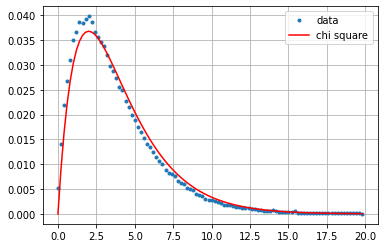

In [18]:
k=5
hist = omnibus(vv_list.slice(0,k)) \
         .reduceRegion(ee.Reducer.fixedHistogram(0, 20, 100),geometry=aoi_sub,scale=10) \
         .get('constant') \
         .getInfo()
 
a = np.array(hist)
x = a[:,0]
y = a[:,1]/np.sum(a[:,1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, k-1)/5, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

It appears that Wilks' Theorem is again a fairly good approximation. So why not generate a change map for the full series? The good news is that we now have the overall false positive probability $\alpha$ under control. Here we set it to $\alpha=0.01$.

In [19]:
def chi2cdf(chi2,df):
    ''' Chi square cumulative distribution function for df degrees of freedom 
        using the built-in incomplete gamma function gammainc() '''
    return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

# The c_map for alpha = 0.01.
p_value = ee.Image.constant(1).subtract(chi2cdf(omnibus(vv_list),23))
c_map = p_value.multiply(0).where(p_value.lt(0.01),1).clip(aoi)
c_map = c_map.updateMask(c_map.gt(0))    
# Project onto map.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=11, height=800, width=1000)
mp.add_ee_layer(c_map, {'min': 0,'max': 1, 'palette': ['black','red']}, 'Change map')
mp.add_child(folium.LayerControl())

So plenty of changes, but hard to interpret considering the time span. Although we can see _where_ changes took place, we know neither _when_ they occurred nor their _multiplicity_. Also there is a matter that we have glossed over up until now, and that is ...

### A question of scale

The number of looks plays an important role in all of the statistical tests that we have discussed so far, and for the Sentinel-1 ground range detected imagery we have used $m=5$ throughout. (Later we'll prefer to use the equivalent number of looks ENL$=4.4$ that we introduced at the end of Part 1.) When we display a change map interactively, the zoom factor determines the image pyramid level at which the servers perform the required calculations and pass the result to the client. If the calculations are not at the nominal scale of 10m then the number of looks is effectively larger than 5 due to the averaging involved in constructing higher pyramid levels. The effect can be seen easily in the above folium map: the number of change pixels seems to decrease when we zoom out. There is no problem when we export our results to GEE assets, to Google Drive or to Cloud storage, since we can simply choose the nominal scale for export. 

However, in order to see the changes correctly at all zoom levels, we must force GEE to work at the nominal scale by reprojecting before displaying on the map: 

In [20]:
c_map_10m = c_map.reproject(c_map.projection().crs(), scale=10)
mp = folium.Map(location=location, zoom_start=11, height=800, width=1000)
mp.add_ee_layer(c_map, {'min': 0,'max': 1, 'palette': ['black','red']}, 'Change map')
mp.add_ee_layer(c_map_10m, {'min': 0,'max': 1, 'palette': ['black','blue']}, 'Change map (10m)')

mp.add_child(folium.LayerControl())

You will notice in the output cell above that the calculation at nominal scale (the blue pixels) now takes considerably longer to complete. So for previewing purposes one can probably do without the reprojection.

### A general omnibus test
Recalling the last remark at the end of Part 2, let's now guess the omnibus LRT for the bivariate case. From Eq. (3.5), replacing $s_i$ with $c_i$ and $k^k$ with $k^{2k}$, we get 
 
$$
Q =  \left[k^{2k}{\prod_i |c_i|\over |\sum_i c_i|^k}\right]^m. \tag{3.7}
$$
 
This is a special case of the more general formula
 
$$
Q =  \left[k^{pk}{\prod_i |c_i|\over |\sum_i c_i|^k}\right]^m, \tag{3.8}
$$
 
where $p$ is the dimension of the covariance matrices $c_i$. For single polarization, $p=1$, for dual polarization, e.g., Sentinel-1, $p=2$ and for quad polarization, e.g., Radarsat-2, $p=3$. Equation (3.8) holds for diagonal, block diagonal and full polarimetric complex covariance matrix SAR images, see [Conradsen et al. (2016)](https://ieeexplore.ieee.org/document/7398022). Again for the mathematically inclined, the single polarization image pixels $s_i$ are gamma distributed (as we have seen) and the full dual or quad polarization pixels $c_i$ have a [Complex Wishart distribution](https://en.wikipedia.org/wiki/Complex_Wishart_distribution).
 
Which brings us to the heart of this Tutorial. We will now decompose Eq. (3.5) into a product of independent likelihood ratio tests which will enable us to determine when changes occurred at each pixel location. After that, we will find it easy to guess the  corresponding decomposition of Eq. (3.7). Finally, we'll code the multitemporal change detection algorithm for Sentinel-1 time series on GEE.

### A sequential omnibus test



- instensity version (VV) (show independence with scatterplot)

- bivariate C2

- Loewner order

- ATSF

- median filter


In [30]:
def det(im):
    return im.expression('b(0)*b(1)')

def log_det_sum(im_list,j):
    '''return the log of the the determinant of the sum of the first j images in im_list'''
    im_ist = ee.List(im_list)
    sumj = ee.ImageCollection(im_list.slice(0,j)).reduce(ee.Reducer.sum())                
    return ee.Image(det(sumj)).log()  

def log_det(im_list,j):
    '''return the log of the the determinant of the jth image in im_list'''
    im = ee.Image(ee.List(im_list).get(j.subtract(1)))
    return ee.Image(det(im)).log()      

def pval(im_list,j):
    im_list = ee.List(im_list)
    p = ee.Number(2)
    m = ee.Number(5)
    m2logRj = log_det_sum(im_list,j.subtract(1)) \
             .multiply(j.subtract(1)) \
             .add(log_det(im_list,j))  \
             .add(p.multiply(j).multiply(j.log())) \
             .subtract(p.multiply(j.subtract(1)).multiply(j.subtract(1).log())) \
             .subtract(log_det_sum(im_list,j).multiply(j)) \
             .multiply(-2).multiply(m)
    return ee.Image.constant(1).subtract(chi2cdf(m2logRj,p))             

def js_iter(current,prev):
    j = ee.Number(current) 
    prev = ee.Dictionary(prev)   
    im_list = prev.get('im_list')
    pvs = ee.List(prev.get('pvs'))
    pv = pval(im_list, j)
    return ee.Dictionary({'im_list': im_list, 'pvs': pvs.add(pv)})

def ells_iter(current, prev):
    ell = ee.Number(current)    
    prev = ee.Dictionary(prev)
    k = ee.Number(prev.get('k'))
    im_list = ee.List(prev.get('im_list'))
    pv_arr = ee.List(prev.get('pv_arr'))
    im_list_ell = im_list.slice(ell.subtract(1))
    js = ee.List.sequence(2,k.subtract(ell).add(1))
    first = ee.Dictionary({'im_list': im_list_ell, 'pvs': ee.List([])})
    result = ee.Dictionary(js.iterate(js_iter, first))
    pvs = ee.List(result.get('pvs'))
    return ee.Dictionary({'k': k, 'im_list': im_list, 'pv_arr': pv_arr.add(pvs)})

def omnibus(im_list):
    im_list = ee.List(im_list)
    k = im_list.length()
#  pre-calculate the P-value array    
    ells = ee.List.sequence(1,k.subtract(1))
    first = ee.Dictionary({'k': k, 'im_list': im_list, 'pv_arr': ee.List([])})
    result = ee.Dictionary(ells.iterate(ells_iter,first))
    pv_arr = ee.List(result.get('pv_arr'))